In [102]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import spacy
import string
import random
import pickle as pkl
import time 
import os
from os import listdir 
from collections import Counter
from tqdm import tqdm_notebook
from functools import partial 
import nltk
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

# Import and Process Data 

In [2]:
# helper methods to load reviews from directories 

def load_single_review(fdir, fname): 
    """ Takes as input file directory and file name of a single review, returns review as string """
    fpath = fdir + '/' + fname 
    with open(fpath, 'r') as f: 
        review = f.read()
        return review 
    
def load_dir_reviews(fdir): 
    """ Takes as input file directory where reviews are stored, returns them as a list of review strings """
    fnames = [f for f in listdir(fdir)]
    reviews = [load_single_review(fdir, fname) for fname in fnames]
    return reviews

def combine_data(neg_reviews, pos_reviews): 
    """ Combines lists of negative and positive reviews, returns a combined dataset comprising reviews and labels """
    neg_with_labels = [(review, 0) for review in neg_reviews] 
    pos_with_labels = [(review, 1) for review in pos_reviews]
    combined = neg_with_labels + pos_with_labels
    combined = random.sample(combined, len(combined))
    reviews = [comb[0] for comb in combined]
    labels = [comb[1] for comb in combined]
    return reviews, labels 

In [3]:
# load reviews into lists 
train_val_neg = load_dir_reviews('aclImdb/train/neg')
train_val_pos = load_dir_reviews('aclImdb/train/pos')
test_neg = load_dir_reviews('aclImdb/test/neg')
test_pos = load_dir_reviews('aclImdb/test/pos')

In [4]:
# randomly split train into train vs. validation sets 
train_split = int(20000 / 2) 
train_neg = train_val_neg[:train_split]
train_pos = train_val_pos[:train_split]
val_neg = train_val_neg[train_split:]
val_pos = train_val_pos[train_split:]

In [5]:
# combine pos and neg reviews to get unified datasets 
train_data, train_labels = combine_data(train_neg, train_pos)
val_data, val_labels = combine_data(val_neg, val_pos)
test_data, test_labels = combine_data(test_neg, test_pos)
print ("Train dataset size is {}".format(len(train_data)))
print ("Validation dataset size is {}".format(len(val_data)))
print ("Test dataset size is {}".format(len(test_data)))

Train dataset size is 20000
Validation dataset size is 5000
Test dataset size is 25000


# Tokenization

In [100]:
# helper functions to tokenize reviews 

tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation 
spacy_stop_words = tokenizer.Defaults.stop_words
nltk_stop_words = nltk.corpus.stopwords.words('english')

def lower_case(parsed):
    """ Takes text as input and outputs a list of tokens in lowercase without punctuation """
    return [token.text.lower() for token in parsed]

def tokenize_dataset(dataset, processing_func):
    """ Takes as input a dataset comprising a list of reviews, outputs the tokenized dataset along with 
        a list comprising all the tokens from the dataset """
    token_dataset = []
    for sample in tqdm_notebook(tokenizer.pipe(dataset, 
                                               disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=1)):
        tokens = processing_func(sample)
        token_dataset.append(tokens)
    return token_dataset

def tokenize_dataset_to_disk(dataset, processing_func, filename): 
    """ Tokenize dataset as save as pickle to destination path """
    start_time = time.time() 
    token_dataset = tokenize_dataset(dataset, processing_func)
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))
    with open(filename, "wb") as f: 
        pkl.dump(token_dataset, f)
    time_elapsed = (time.time() - start_time) / 60.0 
    print("Data tokenized and saved as {} in {:.1f} minutes".format(filename, time_elapsed))
    return token_dataset
    
def tokenize_datasets_to_disk(train_data, val_data, test_data, processing_func, folder_name): 
    """ Tokenizes train, val, test datasets and save as pickle to data subfolder 
        Also returns tokenized datasets
    """
    train_data_tokens = tokenize_dataset_to_disk(train_data, processing_func, 
                                                 "data/{}/train_data_tokens.p".format(folder_name))
    val_data_tokens = tokenize_dataset_to_disk(val_data, processing_func, 
                                               "data/{}/val_data_tokens.p".format(folder_name))    
    test_data_tokens = tokenize_dataset_to_disk(test_data, processing_func, 
                                                "data/{}/test_data_tokens.p".format(folder_name))
    return train_data_tokens, val_data_tokens, test_data_tokens


In [103]:
train_data_tokens, val_data_tokens, test_data_tokens = tokenize_datasets_to_disk(
    train_data, val_data, test_data, processing_func=lower_case, folder_name='standard')


Data tokenized and saved as data/standard/train_data_tokens.p in 0.6 minutes



Data tokenized and saved as data/standard/val_data_tokens.p in 0.1 minutes



Data tokenized and saved as data/standard/test_data_tokens.p in 0.8 minutes


In [105]:
# load saved tokens 
train_data_tokens = pkl.load(open("data/standard/train_data_tokens.p", "rb"))
val_data_tokens = pkl.load(open("data/standard/val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("data/standard/test_data_tokens.p", "rb"))

# double check 
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [106]:
# create vocabulary from 10000 most common tokens in the training set 

PAD_IDX=0
UNK_IDX=1

def build_vocab(all_tokens, max_vocab_size=10000, pad_idx=PAD_IDX, unk_idx=UNK_IDX): 
    """ Takes list of all tokens and returns:
        - id2token: list of tokens, where id2token[i] returns token that corresponds to i-th token 
        - token2id: dictionary where keys represent tokens and corresponding values represent their indices
    """
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2, 2+len(vocab))))
    id2token = ['<pad>', '<unk>'] + id2token 
    token2id['<pad>'] = pad_idx
    token2id['<unk>'] = unk_idx
    return token2id, id2token 
    
token2id, id2token = build_vocab(all_train_tokens, max_vocab_size = 10000)

In [107]:
# check the dictionary by loading random token from it

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 9982 ; token gillian
Token gillian; token id 9982


In [108]:
# convert token to id in the dataset 

def token2index_dataset(tokens_data, token2id, unk_idx=UNK_IDX): 
    """ Converts data from word tokens to token indices """
    indices_data = []
    for datum in tokens_data: 
        index_list = [token2id[token] if token in token2id else unk_idx for token in datum]
        indices_data.append(index_list)
    return indices_data 

train_data_indices = token2index_dataset(train_data_tokens, token2id)
val_data_indices = token2index_dataset(val_data_tokens, token2id)
test_data_indices = token2index_dataset(test_data_tokens, token2id)

In [109]:
# check size of data 
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [110]:
# check tokenization of dataset 
print(train_data_tokens[0])
print(train_data_indices[0])

['i', 'disliked', 'this', 'film', 'intensely', 'and', 'left', 'during', 'the', 'scene', 'where', 'the', 'loyalist', 'gang', 'are', 'shot', 'up', 'by', 'the', 'british', '.', 'the', 'film', 'effectively', 'blames', 'the', 'people', 'of', 'ni', 'as', 'being', 'the', 'cause', 'of', 'their', 'own', 'troubles', '.', 'it', 'suggests', 'that', 'the', '25', 'year', 'war', 'was', 'a', 'question', 'of', 'intransigence', 'and', 'nothing', 'to', 'do', 'with', 'britain', "'s", 'partition', 'of', 'ireland', 'and', 'domination', 'of', 'its', 'history', 'i.e.', 'ni', 'was', 'created', 'by', 'britain', 'in', '1921', 'irrespective', 'of', 'the', 'wishes', 'of', 'the', 'rest', 'of', 'ireland.<br', '/><br', '/>the', 'characters', 'are', 'portrayed', 'as', 'hapless', 'fools', ',', 'even', 'though', 'i', 'despise', 'loyalist', 'paramilitaries', 'they', 'were', 'fighting', 'for', 'a', 'cause', '-', 'maintaining', 'their', 'artificial', 'privileges', 'over', 'the', 'catholic', 'community', '.', 'it', 'is', 'a

# Model Architecture and Data Loader

In [111]:
# define custom dataset class and collate function for data loader 

class MovieReviewsDataset(Dataset): 
    """ 
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, label_list, max_sentence_length): 
        """ 
        Initialize dataset by passing in a list of movie review tokens and a list of labels 
        """
        self.data_list = data_list 
        self.label_list = label_list 
        self.max_sentence_length = max_sentence_length
        assert (len(self.data_list) == len(self.label_list))
        
    def __len__(self): 
        return len(self.data_list)
    
    def __getitem__(self, key): 
        """
        Triggered when dataset[i] is called, outputs a list of tokens, length of list, and label of the data point
        """
        token_idx = self.data_list[key][:self.max_sentence_length]
        label = self.label_list[key]
        return [token_idx, len(token_idx), label]
    
def collate_func(max_sentence_length, batch): 
    """ 
    Customized function for DataLoader that dynamically pads the batch so that the data have the same length
    Note that this takes max_sentence_length as a first argument to be prefilled with a partial function later 
        to facilitate hyperparameter tuning 
    """
    data_list = [] 
    label_list = [] 
    length_list = [] 
    
    for datum in batch:         
        label_list.append(datum[2])
        length_list.append(datum[1])
        # pad data before appending 
        padded_vec = np.pad(array = np.array(datum[0]), 
                            pad_width = ((0, max_sentence_length - datum[1])), 
                            mode = 'constant', constant_values = 0)
        data_list.append(padded_vec)
        
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

In [112]:
# define model architecture and helper methods 

class BagOfWords(nn.Module): 
    """ 
    BagOfWords classification model 
    """
    
    def __init__(self, vocab_size, emb_dim): 
        """ 
        @param vocab_size: size of the vocabulary 
        @param emd_dim: size of the word embedding 
        """
        super().__init__() 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim, 2)
        
    def forward(self, data, length): 
        """ 
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a review
            that is represented using n-gram index. Note that they are padded to have the same length. 
        @param length: an int tensor of size (batch_size), which represents the non-trivial (i.e. non-padded)
            length of each sentence in the data 
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
        
        # return logits
        out = self.linear(out.float())

        return out

# Model Training

In [113]:
# helper functions to train and test model 

def test_model(loader, model): 
    """ 
    Helper function that tests the model's performance on a given dataset 
    @param: loader = data loader for the dataset to test against 
    """
    correct = 0 
    total = 0 
    model.eval() 
    
    for data_batch, length_batch, label_batch in loader: 
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predictions = outputs.max(1, keepdim=True)[1]    
        total += label_batch.size(0)
        correct += predictions.eq(label_batch.view_as(predictions)).sum().item()
        
    return (100 * correct / total)

In [114]:
def train_and_eval(model, optimizer, train_loader, val_loader, num_epochs, print_results=True):  
    """
    Trains model on data from train_loader and evaluates on data from val_loader for num_epochs 
    Returns results as a dictionary comprising epoch, train accuracy, and validation accuracy 
    """
    # train and validate 
    criterion = torch.nn.CrossEntropyLoss()
    results = []
    for epoch in range(num_epochs):
        for i, (data_batch, length_batch, label_batch) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i % 100 == 0 or ((epoch==num_epochs-1) & (i==len(train_loader)-1)):
                result = {} 
                result['epoch'] = epoch + i / len(train_loader)
                result['train_acc'] = test_model(train_loader, model)
                result['val_acc'] = test_model(val_loader, model)       
                results.append(result)

                if print_results: 
                    print('Epoch: {:.2f}, Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'.format(
                        result['epoch'], result['train_acc'], result['val_acc']))
    
    return results 

In [115]:
def run_experiment(train_tokens, val_tokens, train_labels, val_labels, 
                   optimizer, learning_rate, emb_dim, max_vocab_size, max_sentence_length,
                   num_epochs, batch_size=32, print_results=True): 
    
    """ Wraps all processing, training and evaluation steps in a function to facilitate hyperparam tuning. 
        Note that the function takes as input tokenized data rather than raw data since there's significant 
        lag time in generating tokens.  
    """
    
    # build vocab based on max_vocab_size specified 
    all_train_tokens = [item for sublist in train_data_tokens for item in sublist] 
    token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)
    
    # convert tokens to token indices 
    train_data_indices = token2index_dataset(train_data_tokens, token2id)
    val_data_indices = token2index_dataset(val_data_tokens, token2id)
    
    # instantiate PyTorch Dataset object 
    train_dataset = MovieReviewsDataset(train_data_indices, train_labels, max_sentence_length)
    val_dataset = MovieReviewsDataset(val_data_indices, val_labels, max_sentence_length)
    
    # create PyTorch DataLoader
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, 
                                               collate_fn=partial(collate_func, max_sentence_length))
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, 
                                             collate_fn=partial(collate_func, max_sentence_length))
    
    # instantiate model and optimizer 
    model = BagOfWords(len(token2id), emb_dim)
    optim = optimizer(params=model.parameters(), lr=learning_rate)
    
    # train and evaluate 
    results = train_and_eval(model, optim, train_loader, val_loader, num_epochs, print_results=True)
    
    return results 

## Basic Model  

First let's train and evaluate a basic model with a set of arbitrary hyperparameters to make sure the code runs correctly:

In [116]:
results = run_experiment(train_data_tokens, val_data_tokens, train_labels, val_labels, optimizer=Adam, 
                         learning_rate=0.001, emb_dim=100, max_vocab_size=10000, max_sentence_length=200,
                         num_epochs=5, batch_size=32, print_results=True)

Epoch: 0.00, Train Accuracy: 49.95%, Validation Accuracy: 49.96%
Epoch: 0.16, Train Accuracy: 64.78%, Validation Accuracy: 63.18%
Epoch: 0.32, Train Accuracy: 69.47%, Validation Accuracy: 68.48%
Epoch: 0.48, Train Accuracy: 72.06%, Validation Accuracy: 71.18%
Epoch: 0.64, Train Accuracy: 76.30%, Validation Accuracy: 73.98%
Epoch: 0.80, Train Accuracy: 78.39%, Validation Accuracy: 75.24%
Epoch: 0.96, Train Accuracy: 80.28%, Validation Accuracy: 77.32%
Epoch: 1.00, Train Accuracy: 80.59%, Validation Accuracy: 77.54%
Epoch: 1.16, Train Accuracy: 81.89%, Validation Accuracy: 78.66%
Epoch: 1.32, Train Accuracy: 83.03%, Validation Accuracy: 79.80%
Epoch: 1.48, Train Accuracy: 84.06%, Validation Accuracy: 80.44%
Epoch: 1.64, Train Accuracy: 84.64%, Validation Accuracy: 81.02%
Epoch: 1.80, Train Accuracy: 85.61%, Validation Accuracy: 81.66%
Epoch: 1.96, Train Accuracy: 86.23%, Validation Accuracy: 82.00%
Epoch: 2.00, Train Accuracy: 86.22%, Validation Accuracy: 81.50%
Epoch: 2.16, Train Accura

It looks like we were able to obtain pretty good results already: ~84% accuracy on unseen validation dataset. We will proceed to try different proprocessing and hyperparameters next. 

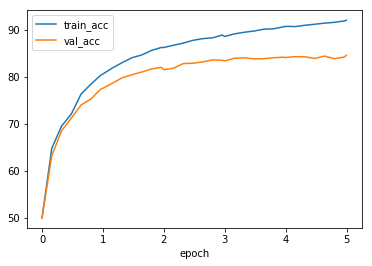

In [117]:
# learning curve 
results_df = pd.DataFrame.from_dict(results)
results_df = results_df.set_index('epoch')
results_df.plot()

## Model Tuning 

#### Tokenization Schemes

In [ ]:
# wrap tokenization process as a function 

# tokenizer = spacy.load('en_core_web_sm')
# punctuations = string.punctuation 
# spacy_stop_words = tokenizer.Defaults.stop_words
# nltk_stop_words = nltk.corpus.stopwords.words('english')

In [ ]:
def lower_case_remove_punc_nltk_stopwords_lemmatize(parsed):
    """ Takes text as input and outputs a list of tokens in lowercase without punctuation """
    return [token.lemma_.lower() for token in parsed 
            if (token.text not in punctuations and token.lemma_.lower() not in nltk_stop_words)]

def lower_case_remove_punc_nltk_stopwords(parsed):
    """ Takes text as input and outputs a list of tokens in lowercase without punctuation """
    return [token.text.lower() for token in parsed 
            if (token.text not in punctuations and token.text.lower() not in nltk_stop_words)]

def lower_case_remove_punc_spacy_stopwords(parsed):
    """ Takes text as input and outputs a list of tokens in lowercase without punctuation """
    return [token.text.lower() for token in parsed 
            if (token.text not in punctuations and token.text.lower() not in spacy_stop_words)]

def lower_case_remove_punc(parsed):
    """ Takes text as input and outputs a list of tokens in lowercase without punctuation """
    return [token.text.lower() for token in parsed if (token.text not in punctuations)]


### N-Gram

In [ ]:
def ngramify(datum_tokens, max_n): 
    """ Generates n-grams up to max_n for one given list of tokens representing a datum """
    result = [] 
    n = max_n 
    
    # decrement n to append ..., 3-grams, 2-grams to result 
    while n >= 1: 
        n_grams = [" ".join(item) for item in list(zip(*[datum_tokens[i:] for i in range(n)]))]
        result = result + n_grams 
        n = n - 1 
        
    # when n=1 just append original tokens
    result = result + datum_tokens  
    
    return result 

In [ ]:
def generate_ngram_dataset(train_tokens, val_tokens, test_tokens, max_n, max_vocab_size):
    """ Takes as input: orignal 1-gram train/val/test tokenized datasets, max_n (for n-gram), max_vocab_size, 
        and returns: 
        - token2id, id2token 
        - train_data_indices, val_data_indices, test_data_indices
    """
    
    # generate ngram tokens 
    train_ngram_tokens = [ngramify(datum, 3) for datum in train_tokens]  
    val_ngram_tokens = [ngramify(datum, 3) for datum in val_tokens]  
    test_ngram_tokens = [ngramify(datum, 3) for datum in test_tokens]  
    all_train_ngram_tokens = [item for sublist in train_ngram_tokens for item in sublist] 
    
    # build vocab 
    token2id, id2token = build_vocab(all_train_ngram_tokens, max_vocab_size)
    
    # convert tokens to indices 
    train_data_indices = token2index_dataset(train_ngram_tokens)
    val_data_indices = token2index_dataset(val_ngram_tokens)
    test_data_indices = token2index_dataset(test_ngram_tokens)
    
    return token2id, id2token, train_data_indices, val_data_indices, test_data_indices

In [ ]:
token2id, id2token, train_data_indices, val_data_indices, test_data_indices = generate_ngram_dataset(
    train_data_tokens, val_data_tokens, test_data_tokens, max_n=2, max_vocab_size=20000)

In [ ]:
emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)
learning_rate = 0.01 
num_epochs = 2
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
total_steps = 0 
results = []

for epoch in range(num_epochs):
    for i, (data_batch, length_batch, label_batch) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and (i+1) % 100 == 0:
            total_steps = epoch * 625 + (i+1) 
            train_acc = test_model(train_loader, model) # report train accuracy 
            val_acc = test_model(val_loader, model) # report validation accuracy 
            result = {} 
            result['step'] = total_steps 
            result['train_acc'] = train_acc
            result['val_acc'] = val_acc        
            results.append(result)
            print('Epoch: [{}/{}], Step: [{}/{}], Total Steps: {}, Validation Acc: {}, Train Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), total_steps, val_acc, train_acc))